In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
import h5py
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import keras
%matplotlib inline

In [21]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU:", tpu.master())
except ValueError:
    print("TPU non disponible")
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
else:
    tpu_strategy = tf.distribute.get_strategy()


Running on TPU: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/

In [22]:
# Chemins
train_path = r'/kaggle/input/fire-data/Data/train'
valid_path = r'/kaggle/input/fire-data/Data/valid'
test_path = r'/kaggle/input/fire-data/Data/test'

In [23]:
def cnn():
    # 1 ere convolution
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 2 eme convolution
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 3 eme convolution
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Aplatissement des sorties des couches de convolution
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    # Ajouter une couche softmax avec 2 classes ( Fire et Non - fire )
    model.add(Dense(2, activation='softmax'))
    
    return model

In [30]:
with tpu_strategy.scope():

    model = build_cnn()
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_path, target_size=(224, 224), batch_size=128)
    valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
        valid_path, target_size=(224, 224), batch_size=128)
    test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_path, target_size=(224, 224), batch_size=128, shuffle=False)

    checkpointer = ModelCheckpoint(
        filepath='/kaggle/working/CNN.keras',
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto',
        save_freq='epoch'
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001)
    
    steps_per_epoch = max(1, train_batches.samples // train_batches.batch_size)
    validation_steps = max(1, valid_batches.samples // valid_batches.batch_size)
    
    for epoch in range(1, 11):
        try:
            print(f"Epoch {epoch}/10")
            model.fit(
                train_batches,
                steps_per_epoch=steps_per_epoch,
                validation_data=valid_batches,
                validation_steps=validation_steps,
                epochs=1,  # Train for one epoch at a time
                verbose=1,
                callbacks=[checkpointer, reduce_lr]
            )
        except StopIteration:
            print("Data generator exhausted. Moving to the next epoch.")
            continue

Found 8000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10


2024-11-03 17:23:24.494232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1730654604.745690    4882 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1c7cd8e96673c531:0:0), session_name()


 3/62 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4653 - loss: 3.5203

I0000 00:00:1730654610.301070    4882 tpu_compile_op_common.cc:245] Compilation of 1c7cd8e96673c531:0:0 with session name  took 5.555333341s and succeeded
I0000 00:00:1730654610.304897    4882 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1c7cd8e96673c531:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6804840540038960622", property.function_library_fingerprint = 4212577781603579411, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,224,224,3,;16,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730654610.304926    4882 tpu_compilation_cache_interface.cc:541] After adding entry for key 

43/62 ━━━━━━━━━━━━━━━━━━━━ 11s 584ms/step - accuracy: 0.6933 - loss: 1.5025

I0000 00:00:1730654635.503000    4941 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7134030e55484d19:0:0), session_name()


47/62 ━━━━━━━━━━━━━━━━━━━━ 9s 622ms/step - accuracy: 0.7052 - loss: 1.4284 

I0000 00:00:1730654638.801780    4941 tpu_compile_op_common.cc:245] Compilation of 7134030e55484d19:0:0 with session name  took 3.298725949s and succeeded
I0000 00:00:1730654638.806584    4941 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7134030e55484d19:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6804840540038960622", property.function_library_fingerprint = 4212577781603579411, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,224,224,3,;8,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730654638.806624    4941 tpu_compilation_cache_interface.cc:541] After adding entry for key 71

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7398 - loss: 1.2254

I0000 00:00:1730654648.484842    4908 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(da9652a0012614ad:0:0), session_name()
I0000 00:00:1730654653.159082    4908 tpu_compile_op_common.cc:245] Compilation of da9652a0012614ad:0:0 with session name  took 4.674198112s and succeeded
I0000 00:00:1730654653.160920    4908 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(da9652a0012614ad:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2727500898359210354", property.function_library_fingerprint = 5569474029868667540, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,224,224,3,;16,2,;", property.guaranteed_constants_size = 0, embe


Epoch 1: val_loss improved from inf to 0.15851, saving model to /kaggle/working/CNN.keras


I0000 00:00:1730654675.183038    4889 tpu_compile_op_common.cc:245] Compilation of 24831b3ecbb0a456:0:0 with session name  took 3.619325014s and succeeded
I0000 00:00:1730654675.184862    4889 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(24831b3ecbb0a456:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2727500898359210354", property.function_library_fingerprint = 5569474029868667540, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,224,224,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730654675.184900    4889 tpu_compilation_cache_interface.cc:541] After adding entry for key 24

62/62 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7439 - loss: 1.2020 - val_accuracy: 0.9421 - val_loss: 0.1585 - learning_rate: 0.0010
Epoch 2/10
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9805 - loss: 0.0824
Epoch 1: val_loss did not improve from 0.15851
62/62 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9804 - loss: 0.0822 - val_accuracy: 0.9277 - val_loss: 0.1833 - learning_rate: 0.0010
Epoch 3/10
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9815 - loss: 0.0460
Epoch 1: val_loss did not improve from 0.15851
62/62 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9816 - loss: 0.0461 - val_accuracy: 0.9029 - val_loss: 0.3229 - learning_rate: 0.0010
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9974 - loss: 0.0195
Epoch 1: val_loss did not improve from 0.15851
62/62 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9973 - loss: 0.0197 - val_accuracy: 0.9194 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 5/10
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 616m

In [31]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [32]:
test_batches.class_indices

{'Fire': 0, 'NonFire': 1}

In [33]:
predictions = model.predict(test_batches, steps=len(test_batches), verbose=1)
predictions

2024-11-03 17:36:41.621200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_6_1/conv2d_18_1/Reshape/ReadVariableOp.
I0000 00:00:1730655401.652204    4879 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(eb59be357563b445:0:0), session_name()


 2/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step

I0000 00:00:1730655406.524500    4879 tpu_compile_op_common.cc:245] Compilation of eb59be357563b445:0:0 with session name  took 4.872237383s and succeeded
I0000 00:00:1730655406.525781    4879 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(eb59be357563b445:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_7713620612718902167", property.function_library_fingerprint = 6309059248911761041, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730655406.525807    4879 tpu_compilation_cache_interface.cc:541] After adding entry for key eb59be357563

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step

I0000 00:00:1730655420.729830    4916 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8e6e78bf4e07f43a:0:0), session_name()


16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step 


I0000 00:00:1730655425.510326    4916 tpu_compile_op_common.cc:245] Compilation of 8e6e78bf4e07f43a:0:0 with session name  took 4.780451967s and succeeded
I0000 00:00:1730655425.511322    4916 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8e6e78bf4e07f43a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13619037508697582743", property.function_library_fingerprint = 7290269339837116096, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "10,224,224,3,;10,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730655425.511350    4916 tpu_compilation_cache_interface.cc:541] After adding entry

array([[9.9953568e-01, 4.6438814e-04],
       [9.3938118e-01, 6.0618829e-02],
       [3.7086192e-01, 6.2913799e-01],
       ...,
       [8.6134020e-03, 9.9138659e-01],
       [4.6301540e-03, 9.9536985e-01],
       [1.8366165e-03, 9.9816340e-01]], dtype=float32)

In [34]:
predictions_class = np.argmax(predictions, axis=1)
predictions_class[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [35]:
correct_predictions = np.sum(predictions_class == test_labels)
total_examples = len(test_labels)
print(f"Nombre de prédictions correctes : {correct_predictions}")
print(f"Nombre total d'exemples : {total_examples}")

Nombre de prédictions correctes : 1835
Nombre total d'exemples : 2000


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 863ms/step
Confusion matrix, without normalization
[[891 109]
 [ 56 944]]


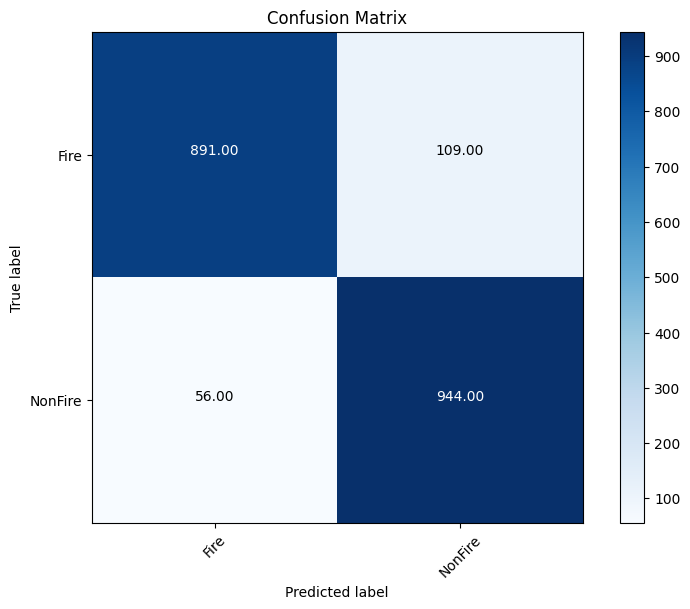

In [36]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predictions = model.predict(test_batches, steps=len(test_batches), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix')
plt.show()

In [40]:

cnn_model = keras.models.load_model('/kaggle/working/CNN.keras')